In [1]:
import sys
sys.path.append('../')

import graph.random_graph as random_graph
import util.create_population as create_population
import core_nn.fit_model as fit_model

import torch
import pandas as pd
import random
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def sim(timeHorizon, model: fit_model.EPI_dense):
  populationNumber= []
  populationExpectation= []
  for i in range(timeHorizon):
    populationNumberi, populationExpectationi= model()
    populationNumber.append(populationNumberi)
    populationExpectation.append(populationExpectationi)
  populationNumber = torch.stack(populationNumber)
  populationExpectation = torch.stack(populationExpectation)

  return populationNumber, populationExpectation

In [3]:
n= 5000
avgDegree= 10
timeHorizon= 40
print("haha")
contact=random_graph.get_ER_random_contact(n, avgDegree, device=device)
print("haha")
contact = contact.requires_grad_(True)
realData =None
with torch.no_grad():
    ps= torch.tensor([[0, 0.2, 0, 0],
                      [0, 0, 0.8, 0],
                      [0, 0, 0, 0.1],
                      [0.01, 0, 0, 0]], device=device)
    population= create_population.population(n, device)
    model= fit_model.EPI_dense(contact, ps, population, device)
    realData, _ =sim(timeHorizon, model)


haha
haha


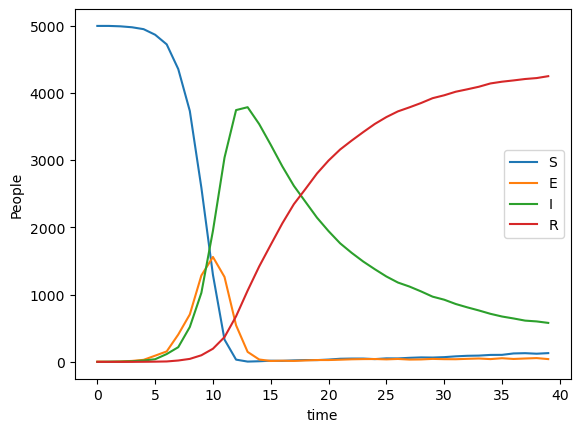

In [4]:
populationNumberPlot= realData.cpu().detach()
plt.plot(populationNumberPlot, label=['S', 'E', 'I', 'R'])
plt.xlabel("time")
plt.ylabel("People")
plt.legend()

In [5]:
realData.requires_grad_(True)
psFit= torch.tensor([[0, 0, 0, 0],
                     [0, 0, 0.0, 0],
                     [0, 0, 0, 0.0],
                     [0.0, 0, 0, 0]], device=device)
cc= torch.tensor([  [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1],
                    [0, 0, 0, 0]], device=device)
populationFit= create_population.population(n, device)
modelFit= fit_model.EPI_dense(contact, psFit, populationFit, device, train=True, cc=cc, recursive=True)
lossFn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(modelFit.parameters(), lr=3e-1)

In [6]:
fitPinfs=[]
#1. choose a better optimiser
#2. bigmodel learn intrinsic, gradient easy model !!!
#3. adaptive constraint?
#4. GAN ?
losses= []
for i in tqdm(range(500)):
    optimizer.zero_grad()
    fitPinfs.append(modelFit.get_psMatrix())
    populationFit= create_population.population(n, device)
    modelFit.reset_population(populationFit)
    fitPopulation, expectation = sim(timeHorizon, modelFit)
    #loss= lossFn(expectation, realData)/n/timeHorizon
    loss= lossFn(expectation[:, 2], realData[:, 2])/n/timeHorizon
    losses.append(loss.item())
    loss.backward(retain_graph=True)
    optimizer.step()
print(modelFit.get_psMatrix())

100%|██████████| 500/500 [01:05<00:00,  7.59it/s]

tensor([[0.0000, 0.1534, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7277, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1110],
        [0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<MulBackward0>)


tensor([[0.0000, 0.1534, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7277, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1110],
        [0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<MulBackward0>)


Text(0, 0.5, 'loss')

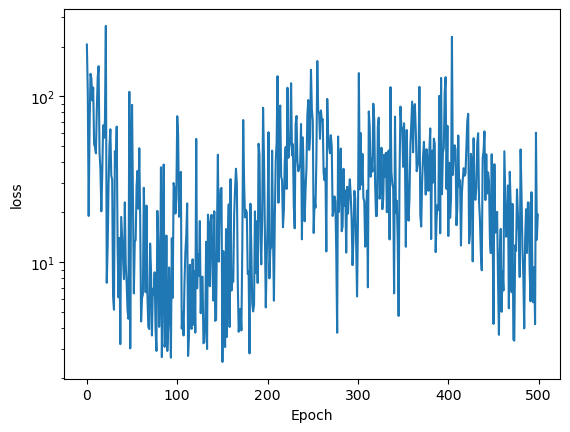

In [7]:
print(modelFit.get_psMatrix())
plt.plot(losses)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("loss")

In [8]:
def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')
print_model_parameters(modelFit)

name           : _psMatrix
parameter      : Parameter containing:
tensor([[ 0.3047, -0.3047,  0.3047,  0.3047],
        [-1.0407, -1.0407,  1.0407, -1.0407],
        [ 0.4910,  0.4910,  0.4910, -0.4910],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0',
       requires_grad=True)
learnable      : True
parameter.shape: torch.Size([4, 4])
parameter.grad: tensor([[ 0.5963, -1.7890,  0.5963,  0.5963],
        [ 3.0237,  3.0237, -9.0710,  3.0237],
        [-0.8985, -0.8985, -0.8985,  2.6956],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
---------------------------------


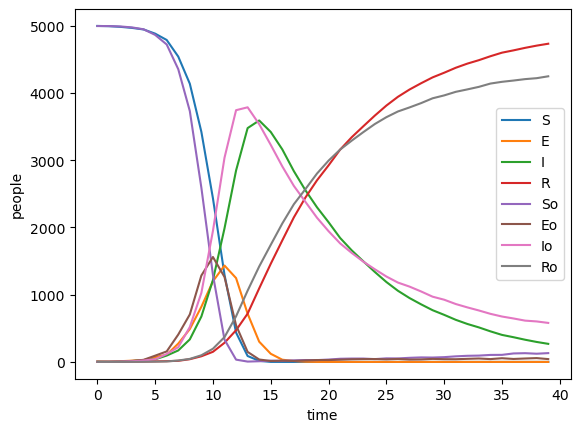

In [9]:
populationNumberPlot2= fitPopulation.cpu().detach()
plt.plot(populationNumberPlot2, label=['S', 'E', 'I', 'R'])
plt.plot(populationNumberPlot, label=['So', 'Eo', 'Io', 'Ro'])
plt.xlabel("time")
plt.ylabel("people")
plt.legend()